# LIME-Aleph

### KI-Campus Aufgabe

Willkommen zum Arbeitsauftrag für das Modul __LIME-Aleph__ im KI-Campus. Hier werden Sie den typischen Ablauf zum Finden einer symbolischen Erklärung für Black-Box Netzwerke mithilfe der LIME-Aleph Bibliothek Stück für Stück erarbeiten.

In [ ]:
from platform import python_version

print(python_version())

In [ ]:
pip freeze

Wir wollen zunächst mal die nötigen Bibliotheken importieren und einige nutzerdefinierbare Parameter erzeugen. Eine zu klassifizierende Bilddatei sowie ein vortrainiertes Modell sind schon vorhanden.

In [ ]:
from ipywidgets import IntProgress

In [1]:
from skimage.util import img_as_float32
from skimage.transform import resize
from train_model import own_rel
import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
from skimage import io
from skimage.io import imshow, show, imsave
import shutil

import lime_aleph as la

NOTEBOOKPATH = "" #
IMAGE_FILE = "./pos9000.png" # The path to the image file to be classified by the black-box
MODEL = "../models_to_explain/model_tower.h5" # The path to the pre-trained model
K = 3 # The number of important superpixels to be used for perturbation
N = 1000 # The sample size for LIME
OUTPUT_DIR = "../output/" # A path for a directory to save intermediate and output data
T = 0.8 # The threshold for the binary classifier for when an example is classified as 'positive'
NOISE = 10 # The allowed false-positive rate for Aleph in percent.

Sollte es noch temporäre Daten aus früheren Durchläufen geben, sollen diese nun gelöscht werden:

In [2]:
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
os.makedirs(OUTPUT_DIR)

Nun wollen wir das Bild und das vortrainierte Modell in den Speicher laden:

In [40]:
image = img_as_float32(io.imread(IMAGE_FILE))
image = resize(image, (own_rel.IMAGE_SIZE, own_rel.IMAGE_SIZE), anti_aliasing=True)

model = own_rel.own_rel()
model.load_weights(MODEL)

io.imshow(image)
io.show()

FileNotFoundError: No such file: '/Users/sees/Documents/IIS/Code/LIME-Aleph/output/pos9000.png'

Der nächste Schritt soll nun sein, die im Bild vorhandenen Elemente automatisch zu annotieren. Benutzen Sie hierfür die Funktion __annotate_image_parts__ aus dem bereits importierten __lime_aleph__ package mit den benötigten Parametern:

In [4]:
#[SOLUTION]

annotated_image = la.annotate_image_parts(image, model, OUTPUT_DIR, N)

Running LIME...
True class of the image is:  1
Negative estimator: 0.023822417
Positive estimator: 0.9761776
Starting the explanation generation process. This may take several minutes. Seriously. Grab a cup of coffee.


/Users/sees/.virtualenvs/lime-aleph/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


  0%|          | 0/1000 [00:00<?, ?it/s]

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Intercept -0.23463660278704856
Prediction_local [0.33396255]
Right: 0.023822423
Intercept 1.2346365973356541
Prediction_local [0.66603746]
Right: 0.9761776
Elapsed time: 3.3394289016723633
Number of superpixels: 64
Annotating the superpixels...
Weight of sp:  44 is:  0.1147492499928618
Weight of sp:  60 is:  0.10612414946491816
Weight of sp:  52 is:  0.09594455199558823
Weight of sp:  48 is:  -0.04471325524619362
Weight of sp:  10 is:  -0.042861667219122955
Weight of sp:  17 is:  -0.040696741842656266
Weight of sp:  53 is:  -0.03873590512069972
Weight of sp:  41 is:  -0.03511165823358521
Weight of sp:  42 is:  -0.03406053637765858
Weight of sp:  50 is:  -0.03400254754601082
Weight of sp:  45 is:  -0.030626829520449806
Weight of sp:  34 is:  -0.029723969870578664
Weight of sp:  54 is:  -0.029345078687959124
Weight of sp:  40 is:  -0.028135710391808816
Weight of sp:  18 is:  -0.027948492920774188
Weight of sp:  57 is:  -0.027840963429139852
Weight of sp:  14 is:  -0.02731158867698219
Wei

Lets do it manually....


In [5]:
import numpy as np
print("Running LIME...")

true_class = -1
predictions = model.predict_proba(np.array([image])) #Probabilities
predictions = np.squeeze(predictions) #to get rid of the third dimension
true_class = np.argmax(predictions)

# the softmax output for the two classes:
print("Negative estimator:", predictions[0])
print("Positive estimator:", predictions[1])

Running LIME...
Negative estimator: 0.023822417
Positive estimator: 0.9761776


/Users/sees/.virtualenvs/lime-aleph/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [33]:
annotated_image = la.Image()
annotated_image.true_class = true_class

annotated_image.original_image = image


from lime import lime_image
from sources.own_segmentation.scikit_image import SegmentationAlgorithm
import time

n_lime_samples=1000

explainer = lime_image.LimeImageExplainer(verbose=True)
print('Starting the explanation generation process. This may take several minutes. Seriously. Grab a cup of coffee.')
sf = SegmentationAlgorithm('quadratic', n_quads=8) # our own segmentation algorithm. A uniform grid.
tmp = time.time()
explanation = explainer.explain_instance(image, model.predict_proba, segmentation_fn=sf, top_labels=2, num_samples=n_lime_samples, hide_color=0)
print("Elapsed time: " + str(time.time() - tmp))

Starting the explanation generation process. This may take several minutes. Seriously. Grab a cup of coffee.


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept -0.20537472337552654
Prediction_local [0.32172826]
Right: 0.023822423
Intercept 1.205374721315089
Prediction_local [0.67827174]
Right: 0.9761776
Elapsed time: 3.3644580841064453


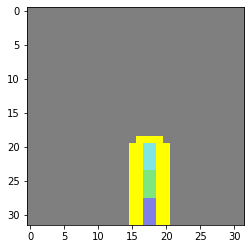

In [39]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries


temp, mask = annotated_image.explanation.get_image_and_mask(true_class, positive_only=True, num_features=3, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

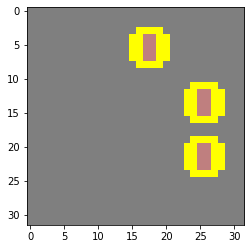

In [41]:
temp, mask = explanation.get_image_and_mask(0, positive_only=True, num_features=3, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Nachdem das Bild nun annotiert ist (als Annotation wurden auch die Gewichte von LIME für die einzelnen Elemente gefunden), können wir nun die wichtigsten __K__ Bildelemente mit der Funktion __find_important_parts__ finden. Anschließend können Sie auch die Relationen zwischen den Bildteilen mit der Funktion __find_spatial_relations__ finden lassen:

In [6]:
#[SOLUTION]

important_superpixels = la.find_important_parts(annotated_image, 4)
relations = la.find_spatial_relations(important_superpixels)

Currently at superpixel 44
Currently at superpixel 60
Currently at superpixel 52
Currently at superpixel 48


In [29]:
vars(annotated_image)

{'true_class': 1,
 'original_image': array([[[0.5019608, 0.       , 0.       ],
         [0.5019608, 0.       , 0.       ],
         [0.5019608, 0.       , 0.       ],
         ...,
         [0.5019608, 0.       , 0.       ],
         [0.5019608, 0.       , 0.       ],
         [0.5019608, 0.       , 0.       ]],
 
        [[0.5019608, 0.       , 0.       ],
         [0.5019608, 0.       , 0.       ],
         [0.5019608, 0.       , 0.       ],
         ...,
         [0.5019608, 0.       , 0.       ],
         [0.5019608, 0.       , 0.       ],
         [0.5019608, 0.       , 0.       ]],
 
        [[0.5019608, 0.       , 0.       ],
         [0.5019608, 0.       , 0.       ],
         [0.5019608, 0.       , 0.       ],
         ...,
         [0.5019608, 0.       , 0.       ],
         [0.5019608, 0.       , 0.       ],
         [0.5019608, 0.       , 0.       ]],
 
        ...,
 
        [[0.5019608, 0.       , 0.       ],
         [0.5019608, 0.       , 0.       ],
         [0.501960

In [ ]:
important_superpixels



In [30]:
vars(important_superpixels[0])


{'id': 44,
 'name': 'sp_44',
 'color': 'darkturquoise',
 'size': 16,
 'lime_weight': 0.1147492499928618,
 'x_coord': 17.5,
 'y_coord': 21.5}

In [31]:
vars(important_superpixels[1])

{'id': 60,
 'name': 'sp_60',
 'color': 'mediumblue',
 'size': 16,
 'lime_weight': 0.10612414946491816,
 'x_coord': 17.5,
 'y_coord': 29.5}

In [32]:
vars(important_superpixels[2])

{'id': 52,
 'name': 'sp_52',
 'color': 'lime',
 'size': 16,
 'lime_weight': 0.09594455199558823,
 'x_coord': 17.5,
 'y_coord': 25.5}

Die Liste, welche von der Funktion zum Finden von Relationen zurückgegeben wurde, beinhaltet Objekte vom Typ __Relation__. Hier geben wir nun beispielhaft die Informationen der ersten Relation aus. Natürlich müssen Sie den Namen der Liste an Ihre Implementation anpassen.

In [7]:
print("Name:", relations[0].name)
print("Start:", relations[0].start)
print("To:", relations[0].to)

Name: bottom_of
Start: 60
To: 44


In [11]:
for idx in relations:
    print(idx.start, "--"+idx.name+"-->", idx.to) 

60 --bottom_of--> 44
52 --under--> 44
52 --bottom_of--> 44
48 --left_of--> 44
44 --top_of--> 60
52 --on--> 60
52 --top_of--> 60
48 --left_of--> 60
44 --on--> 52
44 --top_of--> 52
60 --under--> 52
60 --bottom_of--> 52
48 --left_of--> 52
44 --right_of--> 48
60 --right_of--> 48
52 --right_of--> 48


Der Name beschreibt das Prädikat der räumlichen Relation. Die weiteren Informationen beschreiben die Indices der Start- und Zielelemente der Relation innerhalb des Bildes.

Nun wollen wir das perturbierte Datenset für LIME-Aleph generieren lassen. Benutzen Sie hierzu die Funktion __perturb_instance__ mit den erforderlichen Parametern. Lassen Sie sich auch ausgeben, wie viele Instanzen im neuen Datenset sind (Es wird eine Liste mit Instanzen zurückgegeben).

In [12]:
#[SOLUTION]
perturbed_dataset = la.perturb_instance(annotated_image, relations, model, T)
print("Number of perturbed instances:", len(perturbed_dataset))

Number of perturbed instances: 17


In [28]:
for idx in annotated_image.superpixels:
    print(vars(idx))

{'id': 44, 'name': 'sp_44', 'color': 'darkturquoise', 'size': 16, 'lime_weight': 0.1147492499928618, 'x_coord': 17.5, 'y_coord': 21.5}
{'id': 60, 'name': 'sp_60', 'color': 'mediumblue', 'size': 16, 'lime_weight': 0.10612414946491816, 'x_coord': 17.5, 'y_coord': 29.5}
{'id': 52, 'name': 'sp_52', 'color': 'lime', 'size': 16, 'lime_weight': 0.09594455199558823, 'x_coord': 17.5, 'y_coord': 25.5}
{'id': 48, 'name': 'sp_48', 'color': 'maroon', 'size': 16, 'lime_weight': -0.04471325524619362, 'x_coord': 1.5, 'y_coord': 25.5}
{'id': 10, 'name': 'sp_10', 'color': 'maroon', 'size': 16, 'lime_weight': -0.042861667219122955, 'x_coord': 9.5, 'y_coord': 5.5}
{'id': 17, 'name': 'sp_17', 'color': 'maroon', 'size': 16, 'lime_weight': -0.040696741842656266, 'x_coord': 5.5, 'y_coord': 9.5}
{'id': 53, 'name': 'sp_53', 'color': 'maroon', 'size': 16, 'lime_weight': -0.03873590512069972, 'x_coord': 21.5, 'y_coord': 25.5}
{'id': 41, 'name': 'sp_41', 'color': 'maroon', 'size': 16, 'lime_weight': -0.03511165823

Das ILP-Framework Aleph benötigt mehrere Hilfsdateien, die mit der Funktion __write_aleph_files__ erzeugt werden. Rufen Sie diese Funktion auf. Es sollen alle räumlichen Relationen verwendet werden! Zur Verfügung stehen folgende Relationen: *left_of*, *right_of*, *top_of*, *bottom_of*, *on*, *under*

In [19]:
#[SOLUTION]
used_relations = None # 'None' if you want to allow all relations, otherwise list with following possibilities: ["left_of", "right_of", "top_of", "bottom_of", "on", "under"]
la.write_aleph_files(annotated_image, perturbed_dataset, used_relations, OUTPUT_DIR, NOISE)

Writing the input files for Aleph...
Done.


Schlussendlich muss nun der Induktionsprozess von Aleph angestoßen werden. Dieser Schritt (mit der Funktion __run_aleph__) gibt auch die gefundene Erklärung aus:

In [25]:
#[SOLUTION]
la.run_aleph(OUTPUT_DIR)

[{}]
[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
[{}]
[{}]
[{}]
The explanation was saved to '../output/explanation.txt'


Die Erklärung in Form von Regeln kann nun im angegebenen Ordner in der Datei *explanation.txt* gefunden und interpretiert werden. Wir lesen nun diese Datei aus:

In [26]:
with open(OUTPUT_DIR + "explanation.txt", 'r') as f:
    print(f.read())

true_class(A) :-
   contains(B,A), has_color(B,mediumblue), contains(C,A), has_color(C,lime), 
   top_of_in_ex(C,B,A).



# Interpretation 
...


true_class(A) :-
   contains(B,A), has_color(B,mediumblue), contains(C,A), has_color(C,lime), 
   top_of_in_ex(C,B,A).

## Interpretierte Regel

true_class(Turm) :-
   contains(Blau,Turm), has_color(Blau,mediumblue), contains(Grün,Turm), has_color(Grün,lime), 
   top_of_in_ex(Grün,Blau,Turm).

übersetzt in Satz
Turm ist wahr wenn gilt: Der blaue Klotz gehört zu einem Turm, ... 

[Bild]




